In [1]:
# Including the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Factoring the dataset

In [2]:
# Import the dataset
df = pd.read_csv('./SPRICE_Norwegian_Maritime_Data.csv')

# Display the first few rows of the dataframe
print(df.head())



             TIMESTAMP  RECORD  BattV_Min  Air_temp_Act  Rel_Humidity_act  \
0  2023-03-15 19:40:00   11445      11.98          -0.9              63.1   
1  2023-03-15 19:41:00   11446      11.98          -0.9              62.7   
2  2023-03-15 19:42:00   11447      11.98          -0.9              65.8   
3  2023-03-15 19:43:00   11448      11.98          -0.8              64.2   
4  2023-03-15 19:44:00   11449      11.98          -0.8              66.2   

   Rel_Air_Pressure  Wind_Speed_avg  Wind_Speed_max  Wind_Direction_vct  \
0            1001.0             3.5             5.2               142.5   
1            1001.0             3.3             5.2               141.3   
2            1001.0             3.4             5.2               147.8   
3            1001.0             3.3             5.3               160.4   
4            1001.0             3.2             5.3               174.7   

   reserved  ...  Wind_Direction_max  Specific_Enthalpy_act  Rain_mV  \
0      -2.9  .

C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_11252\1533437569.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./SPRICE_Norwegian_Maritime_Data.csv')


In [3]:
# Get information about the dataset, including data types and missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276079 entries, 0 to 276078
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TIMESTAMP                    276079 non-null  object 
 1   RECORD                       276079 non-null  int64  
 2   BattV_Min                    276079 non-null  float64
 3   Air_temp_Act                 276079 non-null  float64
 4   Rel_Humidity_act             276079 non-null  float64
 5   Rel_Air_Pressure             276079 non-null  float64
 6   Wind_Speed_avg               276079 non-null  float64
 7   Wind_Speed_max               276079 non-null  float64
 8   Wind_Direction_vct           276079 non-null  float64
 9   reserved                     276079 non-null  float64
 10  Precipitation_Type           276079 non-null  int64  
 11  Precipitation_Intensity      276079 non-null  float64
 12  Dew_Point_act                276079 non-null  float64
 13 

In [4]:
# Check for unique values in a specific column such as 'Precipitation_Type'
unique_precip_types = df['Precipitation_Type'].unique()
print("Unique Precipitation Types:", unique_precip_types)

Unique Precipitation Types: [ 0 70 60]


In [5]:
# Describe the dataset to get statistical summaries for numerical columns
print(df.describe())

              RECORD      BattV_Min   Air_temp_Act  Rel_Humidity_act  \
count  276079.000000  276079.000000  276079.000000     276079.000000   
mean    92999.121273      11.997737       9.406435         72.431792   
std     60815.197658       0.017379       6.125171         14.889859   
min         0.000000      11.960000      -8.100000         20.900000   
25%     40232.500000      11.980000       5.600000         62.200000   
50%     79770.000000      11.990000      10.500000         74.400000   
75%    144539.500000      12.020000      13.600000         84.800000   
max    213617.000000      12.030000      28.500000         99.800000   

       Rel_Air_Pressure  Wind_Speed_avg  Wind_Speed_max  Wind_Direction_vct  \
count     276079.000000   276079.000000   276079.000000       276079.000000   
mean        1011.086362        3.073275        5.158719          157.555982   
std            9.171344        2.813344        4.331517           97.793623   
min          988.200000        0.00

In [6]:
# Identify categorical and continuous variables
categorical_vars = ['TIMESTAMP', 'Precipitation_Type']
continuous_vars = ['Air_temp_Act', 'Rel_Humidity_act', 'Rel_Air_Pressure', 'Wind_Speed_avg']

# Create separate DataFrames for categorical and continuous variables
df_categorical = df[categorical_vars].copy()
df_continuous = df[continuous_vars].copy()

print(df_categorical.head())
print(df_continuous.head())

             TIMESTAMP  Precipitation_Type
0  2023-03-15 19:40:00                   0
1  2023-03-15 19:41:00                   0
2  2023-03-15 19:42:00                   0
3  2023-03-15 19:43:00                   0
4  2023-03-15 19:44:00                   0
   Air_temp_Act  Rel_Humidity_act  Rel_Air_Pressure  Wind_Speed_avg
0          -0.9              63.1            1001.0             3.5
1          -0.9              62.7            1001.0             3.3
2          -0.9              65.8            1001.0             3.4
3          -0.8              64.2            1001.0             3.3
4          -0.8              66.2            1001.0             3.2


In [7]:
# Define new columns that are of interest and filter the DataFrame
new_columns = ['TIMESTAMP', 'Air_temp_Act', 'Rel_Humidity_act', 'Rel_Air_Pressure', 'Wind_Speed_avg', 'Precipitation_Type']
df_selected = df[new_columns].copy()

### Create new dataframe

In [8]:
# Handling missing data - show all rows with any missing data
print(df_selected[df_selected.isnull().any(axis=1)])

Empty DataFrame
Columns: [TIMESTAMP, Air_temp_Act, Rel_Humidity_act, Rel_Air_Pressure, Wind_Speed_avg, Precipitation_Type]
Index: []


In [9]:
# Standard deviation threshold for binning continuous variables
num_std_dev = 1

# Labels dictionary for binning continuous variables
labels = {
    'Air_temp_Act': ['low', 'mid', 'high'],
    'Rel_Humidity_act': ['low', 'mid', 'high'],
    'Rel_Air_Pressure': ['low', 'mid', 'high'],
    'Wind_Speed_avg': ['low', 'mid', 'high']
}

# Create bounds for continuous labels and categorize data
for col in labels:
    col_mean = df[col].mean()
    col_std = df[col].std()
    lower_bound = col_mean - col_std * num_std_dev
    upper_bound = col_mean + col_std * num_std_dev
    bins = [-np.inf, lower_bound, upper_bound, np.inf]
    df[col] = pd.cut(df[col], bins=bins, labels=labels[col])

# Display updated DataFrame with binned categories
print(df.head())

             TIMESTAMP  RECORD  BattV_Min Air_temp_Act Rel_Humidity_act  \
0  2023-03-15 19:40:00   11445      11.98          low              mid   
1  2023-03-15 19:41:00   11446      11.98          low              mid   
2  2023-03-15 19:42:00   11447      11.98          low              mid   
3  2023-03-15 19:43:00   11448      11.98          low              mid   
4  2023-03-15 19:44:00   11449      11.98          low              mid   

  Rel_Air_Pressure Wind_Speed_avg  Wind_Speed_max  Wind_Direction_vct  \
0              low            mid             5.2               142.5   
1              low            mid             5.2               141.3   
2              low            mid             5.2               147.8   
3              low            mid             5.3               160.4   
4              low            mid             5.3               174.7   

   reserved  ...  Wind_Direction_max  Specific_Enthalpy_act  Rain_mV  \
0      -2.9  ...               138.1  

# Creating Bayes Nets

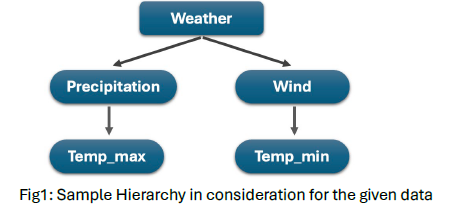

In [10]:

# Define the hierarchy of the network
bn_model = BayesianNetwork([
    ('Air_temp_Act', 'Rel_Humidity_act'), ('Air_temp_Act', 'Wind_Speed_avg'),
    ('Rel_Humidity_act', 'Rel_Air_Pressure'),
    ('Wind_Speed_avg', 'Rel_Air_Pressure')
])

# Define state names for each variable
air_temp_states = ['low', 'mid', 'high']
rel_humidity_states = ['low', 'mid', 'high']
wind_speed_states = ['low', 'mid', 'high']
rel_air_pressure_states = ['low', 'mid', 'high']



In [11]:
# Check if necessary columns exist to avoid KeyError
required_columns = ['Air_temp_Act', 'Rel_Humidity_act', 'Wind_Speed_avg', 'Rel_Air_Pressure']
if not all(col in df.columns for col in required_columns):
    raise ValueError("Not all required columns are present in the dataframe.")


# Marginal probability of Air_temp_Act
air_temp_counts = df['Air_temp_Act'].value_counts()
air_temp_total = air_temp_counts.sum()
air_temp_marginal = np.array([[count / air_temp_total] for count in air_temp_counts])

# Marginal probability of Wind_Speed_avg (assuming it's a root node)
# wind_speed_counts = df['Wind_Speed_avg'].value_counts()
# wind_speed_total = wind_speed_counts.sum()
# wind_speed_marginal = np.array([[count / wind_speed_total] for count in wind_speed_counts])

# Create a dictionary to store CPD arrays
cpd_dict = {}

# Conditional probability of Rel_Humidity_act given Air_temp_Act
humidity_given_temp = df.groupby('Air_temp_Act')['Rel_Humidity_act'].value_counts(normalize=True).unstack(fill_value=0)
cpd_dict['Rel_Humidity_act'] = humidity_given_temp.reindex(columns=rel_humidity_states, fill_value=0).to_numpy().T

# Conditional probability of Wind_Speed_avg given Air_temp_Act
wind_speed_given_temp = df.groupby('Air_temp_Act')['Wind_Speed_avg'].value_counts(normalize=True).unstack(fill_value=0)
cpd_dict['Wind_Speed_avg'] = humidity_given_temp.reindex(columns=rel_humidity_states, fill_value=0).to_numpy().T

# Conditional probability of Rel_Air_Pressure given Wind_Speed_avg
pressure_given_wind = df.groupby(['Rel_Humidity_act', 'Wind_Speed_avg'])['Rel_Air_Pressure'].value_counts(normalize=True).unstack(fill_value=0)
cpd_dict['Rel_Air_Pressure'] = pressure_given_wind.reindex(columns=rel_air_pressure_states, fill_value=0).to_numpy().T

# Fill missing states with a uniform distribution if no data is present (example for simplicity)
for key, matrix in cpd_dict.items():
    if np.isnan(matrix).any():
        matrix[np.isnan(matrix)] = 1 / matrix.shape[0] # Uniform distribution for missing data

# Normalize each CPD matrix
for key, matrix in cpd_dict.items():
    row_sums = matrix.sum(axis=0, keepdims=True)
    cpd_dict[key] = matrix / row_sums # Normalize

# Ensure matrices are stored in cpd_dict correctly
print("CPD Matrices:")
for key, value in cpd_dict.items():
    print(f"{key}:\n{value}\n")


CPD Matrices:
Rel_Humidity_act:
[[0.33985126 0.11184171 0.32255648]
 [0.58889617 0.65490155 0.65793732]
 [0.07125257 0.23325675 0.0195062 ]]

Wind_Speed_avg:
[[0.33985126 0.11184171 0.32255648]
 [0.58889617 0.65490155 0.65793732]
 [0.07125257 0.23325675 0.0195062 ]]

Rel_Air_Pressure:
[[0.07365439 0.22143663 0.40393129 0.04446915 0.13053691 0.22588053
  0.18278368 0.17845758 0.18703507]
 [0.71671388 0.55352279 0.46325483 0.80016676 0.66675728 0.66570717
  0.74063723 0.73181751 0.74176408]
 [0.20963173 0.22504058 0.13281388 0.15536409 0.20270581 0.1084123
  0.07657909 0.08972491 0.07120085]]



C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_11252\2376378008.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  humidity_given_temp = df.groupby('Air_temp_Act')['Rel_Humidity_act'].value_counts(normalize=True).unstack(fill_value=0)
C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_11252\2376378008.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_speed_given_temp = df.groupby('Air_temp_Act')['Wind_Speed_avg'].value_counts(normalize=True).unstack(fill_value=0)
C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_11252\2376378008.py:29: FutureWarning: The default of observed=False is deprecat

In [12]:
# Assuming air_temp_marginal is a numpy array of probabilities for each state
cpd_air_temp = TabularCPD(
    variable='Air_temp_Act', 
    variable_card=3,  # Number of categories in 'Air_temp_Act'
    values=air_temp_marginal.reshape(3, 1),  # This should be reshaped if necessary to match (3, 1)
    state_names={'Air_temp_Act': air_temp_states}
)

# Marginal CPD for 'Wind_Speed_avg'
cpd_wind_speed = TabularCPD(
    variable='Wind_Speed_avg',
    variable_card=3,
    values=cpd_dict['Wind_Speed_avg'],
    evidence=['Air_temp_Act'],
    evidence_card=[3],
    state_names={'Wind_Speed_avg': wind_speed_states, 'Air_temp_Act': air_temp_states}
)

# Conditional CPD for 'Rel_Humidity_act' given 'Air_temp_Act'
cpd_rel_humidity = TabularCPD(
    variable='Rel_Humidity_act',
    variable_card=3,
    values=cpd_dict['Rel_Humidity_act'],
    evidence=['Air_temp_Act'],
    evidence_card=[3],
    state_names={'Rel_Humidity_act': rel_humidity_states, 'Air_temp_Act': air_temp_states}
)

# Conditional CPD for 'Rel_Air_Pressure' given 'Wind_Speed_avg'
cpd_rel_air_pressure = TabularCPD(
    variable='Rel_Air_Pressure',
    variable_card=3,
    values=cpd_dict['Rel_Air_Pressure'],
    evidence=['Rel_Humidity_act', 'Wind_Speed_avg'],
    evidence_card=[3, 3],
    state_names={'Rel_Air_Pressure': rel_air_pressure_states, 'Rel_Humidity_act': rel_humidity_states, 'Wind_Speed_avg': wind_speed_states}
)



In [13]:
# Add CPDs and factors to the model
bn_model.add_cpds(cpd_air_temp, cpd_wind_speed, cpd_rel_humidity, cpd_rel_air_pressure)

# Check if model is consistent
bn_model.check_model()

True

In [14]:
# Viewing nodes of the model
bn_model.nodes()

NodeView(('Air_temp_Act', 'Rel_Humidity_act', 'Wind_Speed_avg', 'Rel_Air_Pressure'))

In [15]:
# Viewing edges of the model
bn_model.edges()

OutEdgeView([('Air_temp_Act', 'Rel_Humidity_act'), ('Air_temp_Act', 'Wind_Speed_avg'), ('Rel_Humidity_act', 'Rel_Air_Pressure'), ('Wind_Speed_avg', 'Rel_Air_Pressure')])

In [16]:
# Print the probability table of the air temperature node
print(cpd_air_temp)

# Print the probability table of the wind speed node
print(cpd_wind_speed)

+--------------------+----------+
| Air_temp_Act(low)  | 0.718881 |
+--------------------+----------+
| Air_temp_Act(mid)  | 0.160233 |
+--------------------+----------+
| Air_temp_Act(high) | 0.120886 |
+--------------------+----------+
+----------------------+-----+---------------------+
| Air_temp_Act         | ... | Air_temp_Act(high)  |
+----------------------+-----+---------------------+
| Wind_Speed_avg(low)  | ... | 0.32255648109306645 |
+----------------------+-----+---------------------+
| Wind_Speed_avg(mid)  | ... | 0.6579373164739019  |
+----------------------+-----+---------------------+
| Wind_Speed_avg(high) | ... | 0.0195062024330317  |
+----------------------+-----+---------------------+


In [18]:
# Independcies in the model
bn_model.get_independencies()
# Checking independcies of a particular node
bn_model.local_independencies('Rel_Air_Pressure')

(Rel_Air_Pressure ⟂ Air_temp_Act | Wind_Speed_avg, Rel_Humidity_act)

# Task 1.2

In [19]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(bn_model)

In [21]:

# Question 1: (a) What is the probability of high air pressure when the wind speed is low? 
probs_air_pressure_by_low_wind_speed = inference.query(variables=['Rel_Air_Pressure'], evidence={'Wind_Speed_avg': 'low'})
print(probs_air_pressure_by_low_wind_speed)

prob_high_air_pressure_by_low_wind_speed = probs_air_pressure_by_low_wind_speed.values[2] * 100
print(f"Probability of high air pressure when the wind speed is low: {prob_high_air_pressure_by_low_wind_speed:.4f}%")


# (b) What is the probability of low wind speed when the air pressure is high?
probs_wind_speed_by_high_air_pressure = inference.query(variables=['Wind_Speed_avg'], evidence={'Rel_Air_Pressure': 'high'})
print(probs_wind_speed_by_high_air_pressure)

prob_low_wind_speed_by_high_air_pressure = probs_wind_speed_by_high_air_pressure.values[2] * 100  # Convert fraction to percentage
print(f"Probability of sunny weather when the wind is high: {prob_low_wind_speed_by_high_air_pressure:.4f}%")

+------------------------+-------------------------+
| Rel_Air_Pressure       |   phi(Rel_Air_Pressure) |
+========================+=========================+
| Rel_Air_Pressure(low)  |                  0.0642 |
+------------------------+-------------------------+
| Rel_Air_Pressure(mid)  |                  0.7687 |
+------------------------+-------------------------+
| Rel_Air_Pressure(high) |                  0.1671 |
+------------------------+-------------------------+
Probability of high air pressure when the wind speed is low: 16.7104%
+----------------------+-----------------------+
| Wind_Speed_avg       |   phi(Wind_Speed_avg) |
+======================+=======================+
| Wind_Speed_avg(low)  |                0.2778 |
+----------------------+-----------------------+
| Wind_Speed_avg(mid)  |                0.6673 |
+----------------------+-----------------------+
| Wind_Speed_avg(high) |                0.0549 |
+----------------------+-----------------------+
Probability 

In [23]:
# Question 2:
# (a) Calculate all the possible joint probability and determine the best probable condition. Explain your results
joint_probability = inference.query(variables=['Air_temp_Act', 'Rel_Humidity_act', 'Wind_Speed_avg', 'Rel_Air_Pressure'])
print(joint_probability)

def factor_to_df(factor):
    """Converts a DiscreteFactor object to a pandas DataFrame."""
    # Flatten the values
    flat_values = factor.values.flatten()
    # Create a multi-index from the state names
    index = pd.MultiIndex.from_product(factor.state_names.values(), names=factor.variables)
    # Create the DataFrame
    df = pd.DataFrame(flat_values, index=index, columns=['Probability'])
    return df.reset_index()

# Assuming 'joint_probability' is your DiscreteFactor object from pgmpy
df = factor_to_df(joint_probability)

# Find the row with the maximum probability
max_prob_row = df.loc[df['Probability'].idxmax()]

# Print the most probable condition
print("The most probable condition is:")
print(max_prob_row)



+--------------------+------------------------+----------------------+------------------------+----------------------------------------------------------------------+
| Air_temp_Act       | Rel_Humidity_act       | Wind_Speed_avg       | Rel_Air_Pressure       |   phi(Air_temp_Act,Rel_Humidity_act,Wind_Speed_avg,Rel_Air_Pressure) |
+====================+========================+======================+========================+======================================================================+
| Air_temp_Act(low)  | Rel_Humidity_act(low)  | Wind_Speed_avg(low)  | Rel_Air_Pressure(low)  |                                                               0.0061 |
+--------------------+------------------------+----------------------+------------------------+----------------------------------------------------------------------+
| Air_temp_Act(low)  | Rel_Humidity_act(low)  | Wind_Speed_avg(low)  | Rel_Air_Pressure(mid)  |                                                               0.0595 

In [25]:

# (b) What is the most probable condition for air temperature, humidity and air pressure, combined?
joint_probability = inference.query(variables=['Air_temp_Act', 'Rel_Humidity_act', 'Rel_Air_Pressure'])
print(joint_probability)

def factor_to_df(factor):
    """Converts a DiscreteFactor object to a pandas DataFrame."""
    # Flatten the values
    flat_values = factor.values.flatten()
    # Create a multi-index from the state names
    index = pd.MultiIndex.from_product(factor.state_names.values(), names=factor.variables)
    # Create the DataFrame
    df = pd.DataFrame(flat_values, index=index, columns=['Probability'])
    return df.reset_index()

# Assuming 'joint_probability' is your DiscreteFactor object from pgmpy
df = factor_to_df(joint_probability)

# Find the row with the maximum probability
max_prob_row = df.loc[df['Probability'].idxmax()]

# Print the most probable condition
print("The most probable condition is:")
print(max_prob_row)



+--------------------+------------------------+------------------------+-------------------------------------------------------+
| Air_temp_Act       | Rel_Humidity_act       | Rel_Air_Pressure       |   phi(Air_temp_Act,Rel_Humidity_act,Rel_Air_Pressure) |
+====================+========================+========================+=======================================================+
| Air_temp_Act(low)  | Rel_Humidity_act(low)  | Rel_Air_Pressure(low)  |                                                0.0450 |
+--------------------+------------------------+------------------------+-------------------------------------------------------+
| Air_temp_Act(low)  | Rel_Humidity_act(low)  | Rel_Air_Pressure(mid)  |                                                0.1472 |
+--------------------+------------------------+------------------------+-------------------------------------------------------+
| Air_temp_Act(low)  | Rel_Humidity_act(low)  | Rel_Air_Pressure(high) |                         

In [27]:
# Question 3. Find the probability associated with each Air temperature, given that the wind speed is medium? Explain your result.
prob_weather_by_med_precipitation = inference.query(variables=['Air_temp_Act'], evidence={'Wind_Speed_avg': 'mid'})
print(prob_weather_by_med_precipitation)


+--------------------+---------------------+
| Air_temp_Act       |   phi(Air_temp_Act) |
+====================+=====================+
| Air_temp_Act(low)  |              0.6965 |
+--------------------+---------------------+
| Air_temp_Act(mid)  |              0.1726 |
+--------------------+---------------------+
| Air_temp_Act(high) |              0.1309 |
+--------------------+---------------------+


In [28]:
# Question 4. What is the probability of each air temperature condition given that wind speed is medium and humidity is low or medium? Explain your method and results. How does the result change with the addition of wind factor compared to question 3 of Task 1.2?
for rel_humidity_states in ['low', 'mid']:   
    prob_air_temp_by_low_or_med_humidity = inference.query(variables=['Air_temp_Act'], evidence={'Wind_Speed_avg': 'mid', 'Rel_Humidity_act': rel_humidity_states})
    print(f"Weather given precipitation is medium and wind is {rel_humidity_states}:\n", prob_air_temp_by_low_or_med_humidity)


Weather given precipitation is medium and wind is low:
 +--------------------+---------------------+
| Air_temp_Act       |   phi(Air_temp_Act) |
+====================+=====================+
| Air_temp_Act(low)  |              0.7937 |
+--------------------+---------------------+
| Air_temp_Act(mid)  |              0.0647 |
+--------------------+---------------------+
| Air_temp_Act(high) |              0.1415 |
+--------------------+---------------------+
Weather given precipitation is medium and wind is mid:
 +--------------------+---------------------+
| Air_temp_Act       |   phi(Air_temp_Act) |
+====================+=====================+
| Air_temp_Act(low)  |              0.6731 |
+--------------------+---------------------+
| Air_temp_Act(mid)  |              0.1856 |
+--------------------+---------------------+
| Air_temp_Act(high) |              0.1413 |
+--------------------+---------------------+


# Task 1.3 - Approximate Inference

## Likelihood Weighted Sample

Generates weighted sample(s) from joint distribution of the Bayesian Network, that comply with the given evidence.

In [29]:
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling

In [30]:
# Repeat Q.1. (a) of Task 1.2 - 
# What is the probability of high air pressure when the wind speed is low? 

# Instantiate the Bayesian model sampler
sampler = BayesianModelSampling(bn_model)

# Specify the evidence with the weather condition set to 'sunny'
evidence_conditions = [State('Wind_Speed_avg', 'low')]

# Generate samples using likelihood weighting, based on the given evidence
likelihood_weighted_samples = sampler.likelihood_weighted_sample(
    evidence=evidence_conditions, size=10000)[['Rel_Air_Pressure', '_weight']]

# Aggregate the weights for each wind condition to calculate the total weight for each category
aggregated_weights_by_wind = likelihood_weighted_samples.groupby('Rel_Air_Pressure').sum()

# Normalize the aggregated weights to convert them into probability estimates
normalized_air_pressure_probabilities = aggregated_weights_by_wind / aggregated_weights_by_wind.sum()

# Display the normalized probabilities of each wind condition given that the weather is sunny
normalized_air_pressure_probabilities


Generating for node: Rel_Air_Pressure: 100%|██████████| 4/4 [00:00<00:00, 112.64it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


,_weight
Rel_Air_Pressure,
high,0.163831
low,0.064781
mid,0.771388


In [32]:
prob_high_air_pressure_when_low_wind_speed = normalized_air_pressure_probabilities.values[0][0] * 100  # Convert fraction to percentage
print(f"Probability of high wind when weather is sunny: {prob_high_air_pressure_when_low_wind_speed:.4f}%")

Probability of high wind when weather is sunny: 16.3831%


In [33]:
# Repeat Q.1. (b) of Task 1.2 - 
# What is the probability of low wind speed when the air pressure is high?

# Instantiate the Bayesian model sampler
sampler = BayesianModelSampling(bn_model)

# Define the evidence with the wind condition set to 'high'
evidence_conditions = [State('Rel_Air_Pressure', 'high')]

# Generate samples using likelihood weighting, based on the given evidence
likelihood_weighted_samples = sampler.likelihood_weighted_sample(
    evidence=evidence_conditions, size=10000)[['Wind_Speed_avg', '_weight']]

# Aggregate the weights for each weather condition to calculate the total weight for each category
aggregated_weights_by_weather = likelihood_weighted_samples.groupby('Wind_Speed_avg').sum()

# Normalize the aggregated weights to convert them into probability estimates
normalized_wind_speed_probabilities = aggregated_weights_by_weather / aggregated_weights_by_weather.sum()

# Display the normalized probabilities of each weather condition given that the wind is high
normalized_wind_speed_probabilities


Generating for node: Rel_Air_Pressure: 100%|██████████| 4/4 [00:00<00:00, 116.70it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


,_weight
Wind_Speed_avg,
high,0.054139
low,0.281030
mid,0.664831


In [34]:
prob_sunny_when_high_wind = normalized_wind_speed_probabilities.values[1][0] * 100  # Convert fraction to percentage
print(f"Probability of sunny weather when wind is high: {prob_sunny_when_high_wind:.4f}%")

Probability of sunny weather when wind is high: 28.1030%


## Rejection Sampling

In [35]:
# Repeat Q.2 . (a) of Task 1.2 - 
# Calculate all the possible joint probability and determine the best probable condition. Explain your results

# Instantiate the Bayesian model sampler
sampler = BayesianModelSampling(bn_model)

# Generate samples from the Bayesian network using rejection sampling
sampled_data = sampler.rejection_sample(size=10000)

# List all the columns to group by all variables for joint probability calculation
variable_names = sampled_data.columns.tolist()

# Group by all variables to calculate the frequency of each unique combination
# and reset the index to convert the result into a DataFrame
joint_probability_distribution = sampled_data.groupby(variable_names).size().reset_index(name='Frequency')

# Normalize the frequencies to convert them into probabilities
joint_probability_distribution['Probability'] = joint_probability_distribution['Frequency'] / joint_probability_distribution['Frequency'].sum()

# Sort by probability in descending order to identify the most probable condition
joint_probability_distribution = joint_probability_distribution.sort_values('Probability', ascending=False).reset_index(drop=True)

# Display the joint probability distribution
print(joint_probability_distribution)

# Display the most probable condition
most_probable_condition = joint_probability_distribution.iloc[0]
print(f"The most probable condition is:\n{most_probable_condition}")



Generating for node: Rel_Air_Pressure: 100%|██████████| 4/4 [00:00<00:00, 125.75it/s]

   Air_temp_Act Rel_Humidity_act Wind_Speed_avg Rel_Air_Pressure  Frequency  \
0           low              mid            mid              mid       1637   
1           low              mid            low              mid       1192   
2           low              low            mid              mid        824   
3           low              low            low              mid        608   
4           low              mid            mid             high        511   
..          ...              ...            ...              ...        ...   
71          mid             high           high             high          1   
72         high             high            mid             high          1   
73         high              low           high              low          1   
74         high              mid           high             high          1   
75         high             high            low              low          1   

    Probability  
0        0.1637  
1        0.1192


c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


In [36]:
# Repeat Q.2 . (b) of Task 1.2 - 
# What is the most probable condition for air temperature, humidity and air pressure, combined?

# Instantiate the Bayesian model sampler
sampler = BayesianModelSampling(bn_model)

# Generate samples from the Bayesian network using rejection sampling
rejection_samples = sampler.rejection_sample(size=10000)

# Focus on the variables of interest: 'temperature', 'humidity', and 'air pressure'
selected_variables_samples = rejection_samples[['Air_temp_Act', 'Rel_Humidity_act', 'Rel_Air_Pressure']]

# Calculate the joint probabilities for the selected variables and normalize the results
joint_probabilities = selected_variables_samples.value_counts(normalize=True)

# Identify the most probable condition along with its probability
most_probable_condition = joint_probabilities.idxmax()
most_probable_probability = joint_probabilities.max() * 100

# Output the most probable condition and its associated probability
print("Most probable condition:", most_probable_condition)
print(f"Probability of the most probable condition: {most_probable_probability:.4f}%")


Generating for node: Rel_Air_Pressure: 100%|██████████| 4/4 [00:00<00:00, 131.55it/s]

Most probable condition: ('low', 'mid', 'mid')
Probability of the most probable condition: 30.4800%



c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


## Approx Inference

In [37]:
from pgmpy.inference import ApproxInference

In [39]:
# Repeat Q.3 of Task 1.2 - 
# Find the probability associated with each Air temperature, given that the wind speed is medium? Explain your result.

# Initialize the approximate inference engine for the Bayesian model
approx_infer_engine = ApproxInference(bn_model)

# Define the evidence where wind speed is set to 'medium'
evidence_condition = {'Wind_Speed_avg': 'mid'}

# Perform the query to calculate the probability distribution of air temperature given the evidence
air_temp_probabilities_given_wind_spped = approx_infer_engine.query(variables=['Air_temp_Act'], evidence=evidence_condition)

# Print the resulting probability distribution of weather conditions
print("Probability distribution of air temperature given medium wind speed:")
print(air_temp_probabilities_given_wind_spped)



  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
100%|██████████| 10000/10000 [00:00<00:00, 196387.37it/s]

Probability distribution of air temperature given medium wind speed:
+--------------------+---------------------+
| Air_temp_Act       |   phi(Air_temp_Act) |
+====================+=====================+
| Air_temp_Act(low)  |              0.7018 |
+--------------------+---------------------+
| Air_temp_Act(mid)  |              0.1688 |
+--------------------+---------------------+
| Air_temp_Act(high) |              0.1294 |
+--------------------+---------------------+


# Normal Sampling

In [40]:
# Repeat Q.4 of Task 1.2 - 
# What is the probability of each air temperature condition given that wind speed is medium and humidity is low or medium? 
# Explain your method and results. 
# How does the result change with the addition of wind factor compared to question 3 of Task 1.2?

# Initialize the Bayesian model sampler
sampler = BayesianModelSampling(bn_model)

# Generate a large number of samples from the Bayesian network model
generated_samples = sampler.forward_sample(size=int(1e5))

# Define evidence scenarios where wind speed is 'medium' and humidity is either 'low' or 'medium'
evidence_conditions = [
    {'Wind_Speed_avg': 'mid', 'Rel_Humidity_act': 'low'},
    {'Wind_Speed_avg': 'mid', 'Rel_Humidity_act': 'mid'}
]

# Filter samples based on the evidence conditions
filtered_samples = generated_samples[
    (generated_samples['Wind_Speed_avg'] == 'mid') & 
    ((generated_samples['Rel_Humidity_act'] == 'low') | (generated_samples['Rel_Humidity_act'] == 'mid'))
]

# Calculate the frequency of each air temperature given the evidence
air_temp_frequencies_given_evidence = filtered_samples['Air_temp_Act'].value_counts()

# Normalize the frequencies to obtain probabilities
normalized_air_temp_probabilities = air_temp_frequencies_given_evidence / air_temp_frequencies_given_evidence.sum()

# Print the normalized probabilities of weather conditions given the evidence
print("Normalized probabilities of air temperatures given medium wind speed and humidity being low or medium:")
print(normalized_air_temp_probabilities)

# Comparing to the scenario where only wind speed is medium (from the previous task)
single_evidence_samples = generated_samples[generated_samples['Wind_Speed_avg'] == 'mid']
single_air_temp_frequencies = single_evidence_samples['Air_temp_Act'].value_counts()
normalized_single_air_temp_probabilities = single_air_temp_frequencies / single_air_temp_frequencies.sum()

# Display the comparison
print("\nComparison with only medium wind speed (no specific humidity condition):")
print(normalized_single_air_temp_probabilities)



Generating for node: Rel_Air_Pressure: 100%|██████████| 4/4 [00:00<00:00, 16.70it/s]
c:\Users\Antonio Luque\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


Normalized probabilities of air temperatures given medium wind speed and humidity being low or medium:
Air_temp_Act
low     0.714581
mid     0.145065
high    0.140354
Name: count, dtype: float64

Comparison with only medium wind speed (no specific humidity condition):
Air_temp_Act
low     0.698297
mid     0.171594
high    0.130110
Name: count, dtype: float64
